In [52]:
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary

In [2]:
print(np.__version__)
print(librosa.__version__)

1.26.0
0.10.1


In [3]:
song_path = "data/DSD100subset/Mixtures/Dev/055 - Angels In Amplifiers - I'm Alright/mixture.wav"
song_path

"data/DSD100subset/Mixtures/Dev/055 - Angels In Amplifiers - I'm Alright/mixture.wav"

In [5]:
# Load song
audio_arr, sr = librosa.load(song_path, sr=8192)
audio_arr.shape

(360780,)

In [6]:
# Audio play
Audio(audio_arr, rate=sr)

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

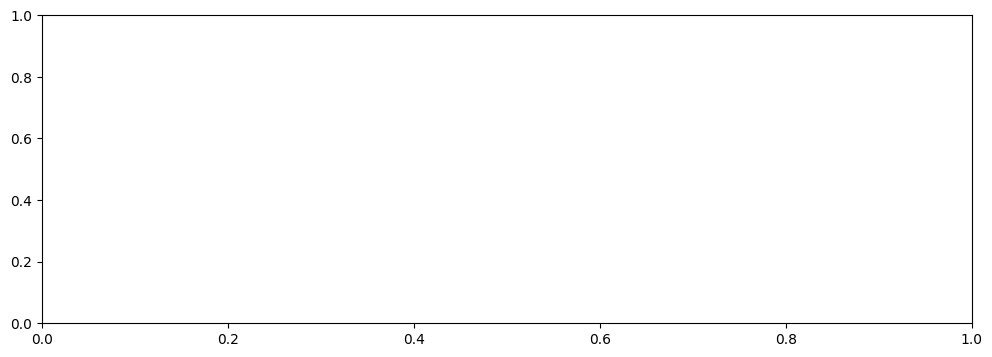

In [12]:
# Display audio array
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_arr, sr=sr)
plt.show()

# STFT

In [14]:
audio_stft = librosa.stft(audio_arr, n_fft=1024, hop_length=768)
audio_stft.shape

(513, 470)

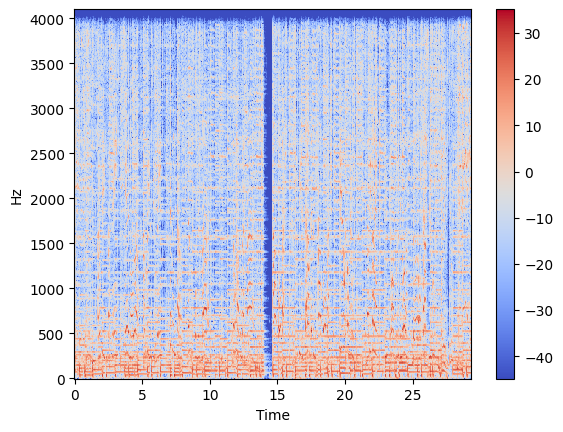

In [16]:
audio_stft_db = librosa.amplitude_to_db(np.abs(audio_stft))
librosa.display.specshow(audio_stft_db, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show()

In [17]:
# Normalize STFT between [0,1]
audio_stft = (np.abs(audio_stft) - np.min(np.abs(audio_stft))) / (
    np.max(np.abs(audio_stft)) - np.min(np.abs(audio_stft))
)

In [19]:
# Select STFT of size (512, 128)
audio = librosa.istft(audio_stft[:, :128], hop_length=768, n_fft=1024)
audio_stft[:, :128].shape

(513, 128)

In [20]:
Audio(audio, rate=sr)

In [26]:
# Convert to spectrogram and save in .npz file
dataset_path = "data/DSD100subset"

mixture_path = dataset_path + "/" + sorted(os.listdir(dataset_path))[0]
sources_path = dataset_path + "/" + sorted(os.listdir(dataset_path))[1]

dev_path = sources_path + "/" + sorted(os.listdir(mixture_path))[0]
test_path = sources_path + "/" + sorted(os.listdir(mixture_path))[1]

sorted(os.listdir(sources_path))

['Dev', 'Test']

In [27]:
song_name = sorted(os.listdir(dev_path))[0]
song_path = dev_path + "/" + song_name

song_path

"data/DSD100subset/Sources/Dev/055 - Angels In Amplifiers - I'm Alright"

In [28]:
sorted(os.listdir(song_path))


['bass.wav', 'drums.wav', 'other.wav', 'vocals.wav']

In [31]:
# dataset_path = "../DSD100"

# mixture_folder_path = dataset_path + "/" + sorted(os.listdir(dataset_path))[0]

# sources_folder_path = dataset_path + "/" + sorted(os.listdir(dataset_path))[1]

rate = 8192
window_size = 1024
hop_lenght = 768

In [32]:
def save_stft(dataset_path, save_path):
    """Save the dataset audio file from dsd100 to a spectrogram.
    While saving the spectrogram the spectrogram will save in the shape of 513,128 by extracting patches
    of 128 frames.

    Parameters
    ----------
    dataset_path :str
        path of DSD100 dataset folder
    save_path : str
        path of the folder where the spectrogram needs to save
    """
    try:
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        mixture_folder_path = dataset_path + "/" + sorted(os.listdir(dataset_path))[0]
        sources_folder_path = dataset_path + "/" + sorted(os.listdir(dataset_path))[1]

        for folder in sorted(os.listdir(mixture_folder_path)):
            mixture_song_folder_path = mixture_folder_path + "/" + folder
            sources_song_folder_path = sources_folder_path + "/" + folder
            for song_name in sorted(os.listdir(mixture_song_folder_path)):
                mixture_path = (
                    mixture_song_folder_path
                    + "/"
                    + song_name
                    + "/"
                    + sorted(os.listdir(mixture_song_folder_path + "/" + song_name))[0]
                )
                # print(mixture_path)
                bass_path = (
                    sources_song_folder_path
                    + "/"
                    + song_name
                    + "/"
                    + sorted(os.listdir(sources_song_folder_path + "/" + song_name))[0]
                )
                # print(bass_path)
                drum_path = (
                    sources_song_folder_path
                    + "/"
                    + song_name
                    + "/"
                    + sorted(os.listdir(sources_song_folder_path + "/" + song_name))[1]
                )
                # print(drum_path)
                vocal_path = (
                    sources_song_folder_path
                    + "/"
                    + song_name
                    + "/"
                    + sorted(os.listdir(sources_song_folder_path + "/" + song_name))[3]
                )
                # print(vocal_path)
                for char in ["&", "'"]:
                    song_name = song_name.replace(char, "")
                print(song_name)
                # load .wav file
                mixture_arr, _ = librosa.load(mixture_path, sr=rate)
                bass_arr, _ = librosa.load(bass_path, sr=rate)
                drum_arr, _ = librosa.load(drum_path, sr=rate)
                vocal_arr, _ = librosa.load(vocal_path, sr=rate)
                instrumental_arr = mixture_arr - vocal_arr

                # use stft on audio file
                mixture_stft = librosa.stft(
                    mixture_arr, n_fft=window_size, hop_length=hop_lenght
                )
                bass_stft = librosa.stft(
                    bass_arr, n_fft=window_size, hop_length=hop_lenght
                )
                drum_stft = librosa.stft(
                    drum_arr, n_fft=window_size, hop_length=hop_lenght
                )
                vocal_stft = librosa.stft(
                    vocal_arr, n_fft=window_size, hop_length=hop_lenght
                )
                instrumental_stft = librosa.stft(
                    instrumental_arr, n_fft=window_size, hop_length=hop_lenght
                )

                index = 1
                for i in range(0, mixture_stft.shape[1], 25):
                    if 128 + i >= mixture_stft.shape[1]:
                        break
                    np.savez(
                        save_path + "/" + song_name + str(index) + ".npz",
                        mixture=mixture_stft[:, 0 + i : 128 + i],
                        bass=bass_stft[:, 0 + i : 128 + i],
                        drum=drum_stft[:, 0 + i : 128 + i],
                        vocal=vocal_stft[:, 0 + i : 128 + i],
                        instrumental=instrumental_stft[:, 0 + i : 128 + i],
                    )
                    index += 1
                # break
    except Exception as e:
        print(e)

    print(".npz file save complete")

In [33]:
dataset_path = "data/DSD100subset"
save_path = "data/DSD100subset_spectrogram"

save_stft(dataset_path, save_path)

055 - Angels In Amplifiers - Im Alright
081 - Patrick Talbot - Set Me Free
005 - Angela Thomas Wade - Milk Cow Blues
049 - Young Griffo - Facade
.npz file save complete


In [35]:
sorted(os.listdir(save_path))

['005 - Angela Thomas Wade - Milk Cow Blues1.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues10.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues11.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues12.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues13.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues14.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues15.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues16.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues2.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues3.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues4.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues5.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues6.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues7.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues8.npz',
 '005 - Angela Thomas Wade - Milk Cow Blues9.npz',
 '049 - Young Griffo - Facade1.npz',
 '049 - Young Griffo - Facade10.npz',
 '049 - Young Griffo - Facade11.npz',
 '049 - Young Griffo - Facade12.npz',
 '049 - Young Griffo - Fac

In [40]:
class DSD100(Dataset):
    def __init__(self, data_path):
        self.spectrogram_path = [
            data_path + "/" + name for name in sorted(os.listdir(data_path))
        ]

    def __len__(self):
        return len(self.spectrogram_path)

    def __getitem__(self, index):
        data = np.load(self.spectrogram_path[index])
        mixture = data["mixture"][np.newaxis, :511, :127]
        bass = data["bass"][np.newaxis, :511, :127]
        drum = data["drum"][np.newaxis, :511, :127]
        vocal = data["vocal"][np.newaxis, :511, :127]
        instrumental = data["instrumental"][np.newaxis, :511, :127]
        return (
            torch.from_numpy(np.abs(np.copy(mixture))).to(device),
            torch.from_numpy(np.abs(np.copy(bass))).to(device),
            torch.from_numpy(np.abs(np.copy(drum))).to(device),
            torch.from_numpy(np.abs(np.copy(vocal))).to(device),
            torch.from_numpy(np.abs(np.copy(instrumental))).to(device),
        )


def data_split(dataset, train_ratio=0.8):
    return random_split(dataset, [train_ratio, 1 - train_ratio])


def dataloader(dataset, batch_size=64, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cpu')

In [42]:
from preprocessing.save_npz import DSD100

dataset = DSD100("data/DSD100subset_spectrogram")

for mixture, bass, drum, vocal, instrumental in dataset:
    print(mixture.shape)
    print(bass.shape)
    print(drum.shape)
    print(vocal.shape)
    print(instrumental.shape)
    break

torch.Size([1, 511, 127])
torch.Size([1, 511, 127])
torch.Size([1, 511, 127])
torch.Size([1, 511, 127])
torch.Size([1, 511, 127])


In [43]:
len(dataset)

55

In [44]:
train_dataset, val_dataset = data_split(dataset, 0.7)
len(train_dataset), len(val_dataset)

(39, 16)

In [45]:
train_dataloader = dataloader(train_dataset, 16, shuffle=True)
val_dataloader = dataloader(val_dataset, 16, shuffle=False)

In [46]:
for mixture, bass, drum, vocal, instrumental in train_dataloader:
    print(mixture.shape)
    print(bass.shape)
    print(drum.shape)
    print(vocal.shape)
    print(instrumental.shape)
    break

torch.Size([16, 1, 511, 127])
torch.Size([16, 1, 511, 127])
torch.Size([16, 1, 511, 127])
torch.Size([16, 1, 511, 127])
torch.Size([16, 1, 511, 127])


In [48]:
from model.network import UNet
model = UNet()

In [53]:
summary(model.to(device), input_size=(1, 511, 127), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [16, 16, 255, 63]             416
       BatchNorm2d-2          [16, 16, 255, 63]              32
         LeakyReLU-3          [16, 16, 255, 63]               0
           encoder-4          [16, 16, 255, 63]               0
            Conv2d-5          [16, 32, 127, 31]          12,832
       BatchNorm2d-6          [16, 32, 127, 31]              64
         LeakyReLU-7          [16, 32, 127, 31]               0
           encoder-8          [16, 32, 127, 31]               0
            Conv2d-9           [16, 64, 63, 15]          51,264
      BatchNorm2d-10           [16, 64, 63, 15]             128
        LeakyReLU-11           [16, 64, 63, 15]               0
          encoder-12           [16, 64, 63, 15]               0
           Conv2d-13           [16, 128, 31, 7]         204,928
      BatchNorm2d-14           [16, 128

In [51]:
!pip install torchsummary


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


# MUSEVAL

In [66]:
import musdb
import museval
import ffmpeg

def estimate_and_evaluate(track):
    # assume mix as estimates
    estimates = {
        'vocals': track.audio,
        'accompaniment': track.audio
    }

    # Evaluate using museval
    scores = museval.eval_mus_track(
        track, estimates, output_dir="data/results"
    )

    # print nicely formatted and aggregated scores
    print(scores)

mus = musdb.DB()
for track in mus:
    estimate_and_evaluate(track)

RuntimeError: ffmpeg or ffprobe could not be found! Please install them before using stempeg. See: https://github.com/faroit/stempeg

In [54]:
pip install musdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 17.6 MB/s eta 0:00:00a 0:00:01
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached ffmpeg_python-0.2.0-py3-none-any.whl (25 kB)
  Using cached future-0.18.3-py3-none-any.whl
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
import musdb
import museval
musdb.DB()

RuntimeError: ffmpeg or ffprobe could not be found! Please install them before using stempeg. See: https://github.com/faroit/stempeg

In [59]:
pip install museval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 4.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [61]:
pip install stempeg


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [64]:
pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=6b7c6a464b48603e49b7416a10672608dd0530ab9b72ed1951cd78c637d999e1
  Stored in directory: /Users/nguyenvietthai/Library/Caches/pip/wheels/1d/57/24/4eff6a03a9ea0e647568e8a5a0546cdf957e3cf005372c0245
Successfully built ffmpeg

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
